# Annotate Homographies
Large scale homography annotation for extraction of next best views.

In [1]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torchvision
import torchvision.io as io
from torchvision.datasets.video_utils import VideoClips
from torch.utils.data import DataLoader
from dotmap import DotMap
import sys

sys.path.append('../')

from utils import load_yaml, save_yaml, dictListToCompose, recursiveMethodCallFromDictList

servers = load_yaml('../config/servers.yml')
server = DotMap(servers['local'])

databases = load_yaml('../config/cholec80_transforms.yml')
database = databases['databases'][0]

In [2]:
# load transforms and convert them to torch.functional methods
key_dict = {
    'Crop': 'crop',
    'Resize': 'resize'
}

functional_databases = copy.deepcopy(databases)
for db_idx, db in enumerate(databases['databases']):
    functional_databases['databases'][db_idx]['transforms'] = [] # delete old transforms
    for transforms in db['transforms']:
        functional_transforms = []
        for transform in transforms:
            # 'Crop' -> 'crop', shape -> height, width, top_left_corner -> top, left
            # 'Resize' -> 'resize', dsize -> size
            functional_transform = {}
            for key, value in transform.items():
                if key == 'Crop':
                    functional_transform[key_dict[key]] = {
                        'height': value['shape'][0],
                        'width': value['shape'][1],
                        'top': value['top_left_corner'][0],
                        'left': value['top_left_corner'][1]
                    }
                elif key == 'Resize':
                    functional_transform[key_dict[key]] = {
                        'size': value['dsize'][::-1]
                    }
                else:
                    raise ValueError('Key not known')

            functional_transforms.append(functional_transform)                
        functional_databases['databases'][db_idx]['transforms'].append(functional_transforms)

save_yaml('../config/cholec80_transforms_functional.yml', functional_databases)

In [2]:
import kornia
import cv2
from kornia import warp_perspective

from utils.processing import image_edges, four_point_homography_to_matrix
from lightning_modules import DeepImageHomographyEstimationModuleBackbone

# load the model
# load best model\n",
model_prefix = '/home/martin/Tresors/homography_imitation_learning_logs/deep_image_homography_estimation_backbone/version_2'
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/unsupervised_deep_homography_estimation_backbone/version_0'
configs = load_yaml(os.path.join(model_prefix, 'config.yml'))
model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(model_prefix, 'checkpoints/epoch=49.ckpt'), shape=configs['model']['shape'])

device = 'cpu'
if torch.cuda.is_available():
    print('Running with CUDA backend.')
    device = 'cuda'

model.to(device)
model = model.eval()
model.freeze()

def forward_model(frame_i, frame_ip1):
    duv = model(frame_i, frame_ip1)

    uv = image_edges(frame_i)
    H = four_point_homography_to_matrix(uv, duv)

    wrp = warp_perspective(frame_i, torch.inverse(H), frame_i.shape[-2:])

    return wrp, H, duv

Running with CUDA backend.


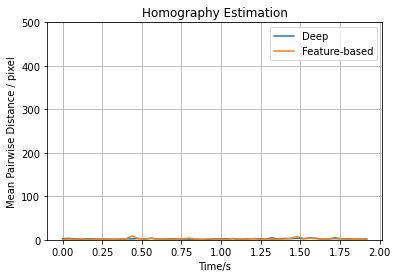

In [4]:
from utils.viz import yt_alpha_blend
from utils.processing import frame_pairs
import time

from datasets import VideoDataset
from utils.processing import FeatureHomographyEstimation
from utils.transforms import anyDictListToCompose
from utils.io import load_pickle, save_pickle, generate_path


meta_df = 'cholec80_dummy_transforms.pkl'
test_metadata_file = 'test.pkl'

n_vids = 1
meta_df = pd.read_pickle(os.path.join(server.config.location, meta_df))[:n_vids]
meta_df.train = False  # artificially set to test set
test_meta_df = meta_df[meta_df.train == False]
test_video_paths = [os.path.join(server.database.location, row.database, row.file['path'], row.file['name']) for _, row in test_meta_df.iterrows()]
test_pre_transforms = [anyDictListToCompose(row.pre_transforms) for _, row in test_meta_df.iterrows()]
test_aug_transforms = [anyDictListToCompose(None) for _, row in test_meta_df.iterrows()]

# load video meta data if existing, returns None if none existent
path = os.path.join(server.config.location, test_metadata_file)
if os.path.exists(path):
    test_metadata = load_pickle(path)
else:
    test_metadata = None


# video reader not compiled yet https://github.com/pytorch/vision/issues/1446
# video reading https://github.com/pytorch/vision/blob/ed5b2dc3a5e7411d8b40cc7e526e151983e99cf9/torchvision/datasets/video_utils.py#L45-L69
# dataset example check https://github.com/pytorch/vision/blob/ed5b2dc3a5e7411d8b40cc7e526e151983e99cf9/torchvision/datasets/kinetics.py#L50-L78


# create video dataset and dataloader
clip_length_in_frames = 50
frame_rate = 25
frames_between_clips = clip_length_in_frames - 1
precomputed_metadata = test_metadata
num_workers = 2
pre_transforms = test_pre_transforms
aug_transforms = test_aug_transforms
seeds = True

vid_ds = VideoDataset(
    video_paths=test_video_paths,
    clip_length_in_frames=clip_length_in_frames,
    frames_between_clips=frames_between_clips,
    frame_rate=frame_rate,
    precomputed_metadata=test_metadata,
    num_workers=num_workers,
    pre_transforms=pre_transforms,
    aug_transforms=aug_transforms,
    seeds=seeds
)

# save metadata
if test_metadata is None:
    save_pickle(os.path.join(server.config.location, test_metadata_file), vid_ds.metadata)

batch_size = 1
drop_last = False

vid_dl = DataLoader(
    vid_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=drop_last
)

print(len(vid_dl))

# classical esimation
with_feature_estimation = True
fd = cv2.xfeatures2d.SIFT_create()
fh = FeatureHomographyEstimation(fd)

df = pd.DataFrame(columns=['t', 'duv_deep', 'duv_ft', 'H_deep', 'H_ft']) # track results
global_idx = 0
max_clips = 150 # vc.num_clips()
max_clips = int(min(max_clips, len(vid_dl)))
out_idx = 0

# live plot of homography norm
duv_list = []
duv_ft_list = []

def live_plot(x, y_0, y_1=None):
    clear_output(wait=True)
    fig = plt.figure()
    plt.ylim(0, 500)
    plt.plot(x, y_0, label='Deep')
    if y_1 is not None:
        plt.plot(x, y_1, label='Feature-based')
    plt.title('Homography Estimation')
    plt.legend(loc='upper right')
    plt.xlabel('Time/s')
    plt.ylabel('Mean Pairwise Distance / pixel')
    plt.grid()
    plt.show()


for batch_idx, batch in enumerate(vid_dl):
    vids, aug_vids, re_sample_frame_rates, frame_rates, vid_idc, clip_idc = batch
    print('\rBatch: {}/{}, BxNxCxHxW: {}, Video/Frame Idices: {}/{}'.format(batch_idx + 1, len(vid_dl), list(vids.shape), vid_idc.numpy().tolist(), clip_idc.numpy().tolist()), end='')

    vids = vids.to(device)

    frames_i, frames_ips = frame_pairs(vids, 1)

    frames_i   = frames_i.reshape((-1,) + frames_i.shape[-3:])      # BxNxCxHxW -> B*NxCxHxW
    frames_ips = frames_ips.reshape((-1,) + frames_ips.shape[-3:])  # BxNxCxHxW -> B*NxCxHxW

    now = time.time_ns()
    wrps, Hs, duvs = forward_model(frames_i, frames_ips)
    print('Forwarding time: {} ms'.format((time.time_ns() - now)/1.e6))  # measure network forwarding time

    global_idx += clip_length_in_frames
    print('\r{}/{}'.format(global_idx, max_clips*clip_length_in_frames), end='')

    frames_i = kornia.tensor_to_image(frames_i)
    frames_ips = kornia.tensor_to_image(frames_ips)
    wrps = kornia.tensor_to_image(wrps)

    for idx, w in enumerate(wrps):
        # classical homography estimation
        if with_feature_estimation:
            H_ft, duv_ft = fh((frames_i[idx]*255).astype(np.uint8), (frames_ips[idx]*255).astype(np.uint8)) # something wrong here!!!

            # warp feature based estimation
            if H_ft is not None:
                wrp_ft = cv2.warpPerspective(frames_i[idx], H_ft, (frames_i[idx].shape[1], frames_i[idx].shape[0]))
            
            if H_ft is not None:
                duv_ft_form = np.linalg.norm(duv_ft, axis=1).mean()
            else:
                duv_ft_form = np.inf

            duv_ft_list.append(duv_ft_form)

            # save results
            df = df.append({
                't': out_idx,
                'duv_deep': duvs[idx].squeeze().cpu().numpy(),
                'duv_ft': duv_ft,
                'H_deep': Hs[idx].squeeze().cpu().numpy(),
                'H_ft': H_ft
            }, ignore_index=True)
        else:
            # save results
            df = df.append({
                't': out_idx,
                'duv_deep': duvs[idx].squeeze().cpu().numpy(),
                'duv_ft': None,
                'H_deep': Hs[idx].squeeze().cpu().numpy(),
                'H_ft': None
            }, ignore_index=True)

        # create moving plot of homography normout_path
        duv_norm = np.linalg.norm(duvs[idx].cpu().numpy(), axis=1).mean()

        duv_list.append(duv_norm)
        if len(duv_list) == clip_length_in_frames:
            duv_list.pop(0)
            if with_feature_estimation:
                duv_ft_list.pop(0)
        if with_feature_estimation:
            live_plot(np.arange(len(duv_list))/frame_rate, duv_list, duv_ft_list)
        else:
            live_plot(np.arange(len(duv_list))/frame_rate, duv_list)

        # plot blends with and without warp
        down_scale = 1.
        blend0 = yt_alpha_blend(frames_ips[idx], w)
        blend1 = yt_alpha_blend(frames_ips[idx], frames_i[idx])
        blend0 = cv2.resize(blend0, (int(blend0.shape[1]/down_scale), int(blend0.shape[0]/down_scale)))
        blend1 = cv2.resize(blend1, (int(blend1.shape[1]/down_scale), int(blend1.shape[0]/down_scale)))

        if with_feature_estimation:
            if H_ft is not None:
                blend2 = yt_alpha_blend(frames_ips[idx], wrp_ft)
                blend2 = cv2.resize(blend2, (int(blend2.shape[1]/down_scale), int(blend2.shape[0]/down_scale)))
            else:
                blend2 = cv2.resize(frames_ips[idx], (int(frames_ip1[idx].shape[1]/down_scale), int(frames_ip1[idx].shape[0]/down_scale)))
            composite = np.concatenate([blend1, blend2, blend0], axis=1)  # none, classical, deep
        else:
            composite = np.concatenate([blend1, blend0], axis=1)  # none, deep

        # # show image
        # cv2.imshow('composite', composite)
        # cv2.waitKey()
        
        # save image
        out_path = 'out/homography_annotation/img/re_sample_frame_rate_{}'.format(frame_rate)
        if not os.path.exists(out_path):
            generate_path(out_path)
        cv2.imwrite(os.path.join(out_path, 'alpha_blend_{}.jpg'.format(out_idx)), composite*255)
        out_idx += 1
cv2.destroyAllWindows()

df.to_pickle('H_re_sample_frame_rate_{}.pkl'.format(frame_rate))


/home/martin/miniconda3/envs/hil/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  This is separate from the ipykernel package so we can avoid doing imports until


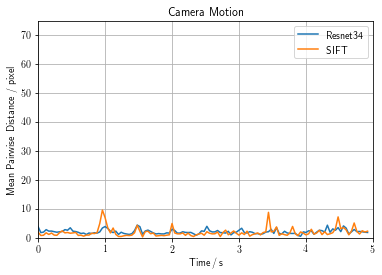

In [8]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

# plot results  
clip_length_in_frames = 100
frame_rate = 25
plot_time = 5. # seconds
df = pd.read_pickle('H_re_sample_frame_rate_{}.pkl'.format(frame_rate))

fig, ax = plt.subplots(1, 1)
fig.patch.set_facecolor((1., 1., 1.))
ax.set_ylim(0, 75)
ax.set_xlim(0, plot_time)
ax.set_title('Camera Motion')
ax.set_xlabel(r'Time$\,/\,$s')
ax.set_ylabel(r'Mean Pairwise Distance / pixel')
line_deep, = ax.plot(np.array(0), np.array(0), label='Resnet34')
line_ft, = ax.plot(np.array(0), np.array(0), label='SIFT')
ax.legend(loc='upper right')
ax.grid()

def create_plot(x, y_0, y_1, idx):
    line_deep.set_data(x, y_0)
    if y_1 is not None:
        line_ft.set_data(x, y_1)
    fig.canvas.draw()
    fig.savefig('out/homography_annotation/plot/re_sample_frame_rate_{}/homography_norm_{}.png'.format(frame_rate, idx), dpi=300)

duv_mpd_deep_list = []
duv_mpd_ft_list = []

for idx, row in df.iterrows():
    duv_mpd_deep_list.append(np.linalg.norm(row.duv_deep, axis=1).mean())
    if row.H_ft is not None:
        duv_mpd_ft_list.append(np.linalg.norm(row.duv_ft, axis=1).mean())
    else:
        duv_mpd_ft_list.append(np.inf)

    if len(duv_mpd_deep_list) == int(plot_time*frame_rate):
        duv_mpd_deep_list.pop(0)
        duv_mpd_ft_list.pop(0)

    create_plot(np.linspace(0, (len(duv_mpd_deep_list)-1)/frame_rate, len(duv_mpd_deep_list)), duv_mpd_deep_list, duv_mpd_ft_list, idx)

In [ ]:
# create a single plot
